In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
data = load_iris()
X, y = data['data'], data['target']
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
def distance(p1 : np.ndarray,p2: np.ndarray) -> np.float64:
    return np.sqrt(np.sum((p1-p2)**2))

def rangeQuery(data, p, eps):
    ret = []
    for i, point in enumerate(data):
        if(distance(p, point) < eps): ret.append((i, point))
    return ret

In [4]:
def dbscan(data, eps : float = 1.5e0 , minPts : int = 3):
    c = 0
    label = [-1 for _ in data] # -1 for noise
    label_counter = -1
    vis = [False for _ in data]
    for i, point in enumerate(data):
        if(vis[i]): continue
        
        vis[i] = True
        queue = rangeQuery(data, point, eps)
        if(len(queue) < minPts):
            continue
        label_counter += 1
        for i, point in queue: label[i] = label_counter
        while(len(queue)):
            current = queue[-1]
            queue.pop()
            neighbors = rangeQuery(data, point, eps)
            if(len(neighbors) < minPts): continue
            for i, point in neighbors:
                if(not vis[i]):
                    queue.append((i, point))
                    vis[i] = True
                    label[i] = label_counter
    
    return label, label_counter

In [5]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def clustering_accuracy(true_labels, predicted_labels):
    """
    Computes clustering accuracy by finding the best label permutation.
    Only works if the number of clusters matches the number of classes.
    """

    true_labels = np.asarray(true_labels)
    predicted_labels = np.asarray(predicted_labels)

    # Build the confusion matrix
    D = max(predicted_labels.max(), true_labels.max()) + 1
    confusion_matrix = np.zeros((D, D), dtype=np.int64)
    for i in range(true_labels.size):
        confusion_matrix[predicted_labels[i], true_labels[i]] += 1

    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    accuracy = confusion_matrix[row_ind, col_ind].sum() / true_labels.size
    return accuracy

In [6]:
parameters_acc = []
biggest_acc = 0
for eps in np.arange(0.1, 3, 0.1):
    for minPts in range(2, 10):
        myDBSCANLabels, myDBSCANLabelCounter = dbscan(X, eps, minPts)
        acc = clustering_accuracy(y, myDBSCANLabels)
        if(biggest_acc < acc):
            biggest_acc = acc
        parameters_acc.append((eps, minPts, acc))
        # print(f"eps: {eps:.3f}, minPts: {minPts}, clusters found: {myDBSCANLabelCounter + 1}, accuracy: {acc:.3f}")
        
print(f"Best accuracy: {biggest_acc:.3f}")

Best accuracy: 0.887


In [7]:
parameters_acc.sort(key=lambda x: x[2], reverse=True)

In [29]:
myDBSCANLabels, myDBSCANLabelCounter = dbscan(X, parameters_acc[0][0], parameters_acc[0][1])
myDBSCANLabels, myDBSCANLabelCounter = dbscan(X, 2, 4)
myDBSCANLabelCounter

5

In [30]:
clustering_accuracy(y, myDBSCANLabels)

np.float64(0.72)

In [31]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS.values())
np.random.shuffle(colors)

In [32]:
np.unique(myDBSCANLabels)

array([0, 1, 2, 3, 4, 5])

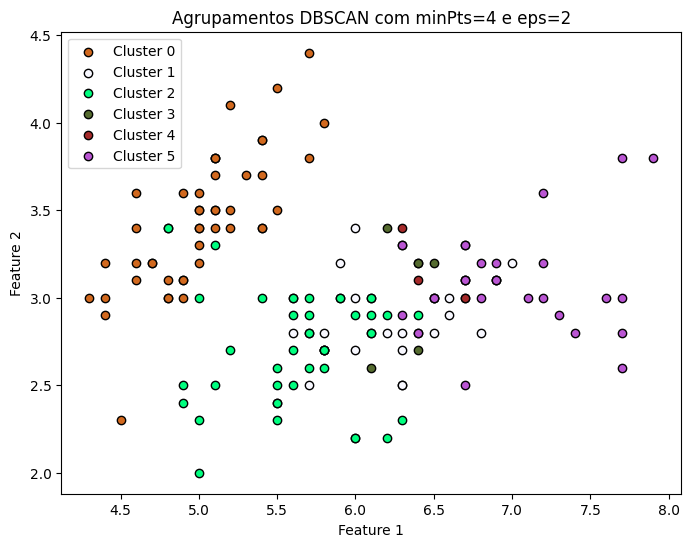

In [34]:
plt.figure(figsize=(8, 6))
for i in np.unique(myDBSCANLabels):
    cluster_points = X[myDBSCANLabels == i]
    color = colors[i % len(colors)]
    label_name = 'Noise' if i == -1 else f'Cluster {i}'
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=label_name, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Agrupamentos DBSCAN com minPts={4} e eps={2}')
plt.legend()
plt.show()


In [35]:
results = []
for eps in np.arange(0.1, 3.5, 0.1, dtype=float):
    line = []
    for minPts in range(2, 10):
        aux = dbscan(X, eps, minPts)
        line.append((clustering_accuracy(y, aux[0]), aux[1]))
    results.append(line)

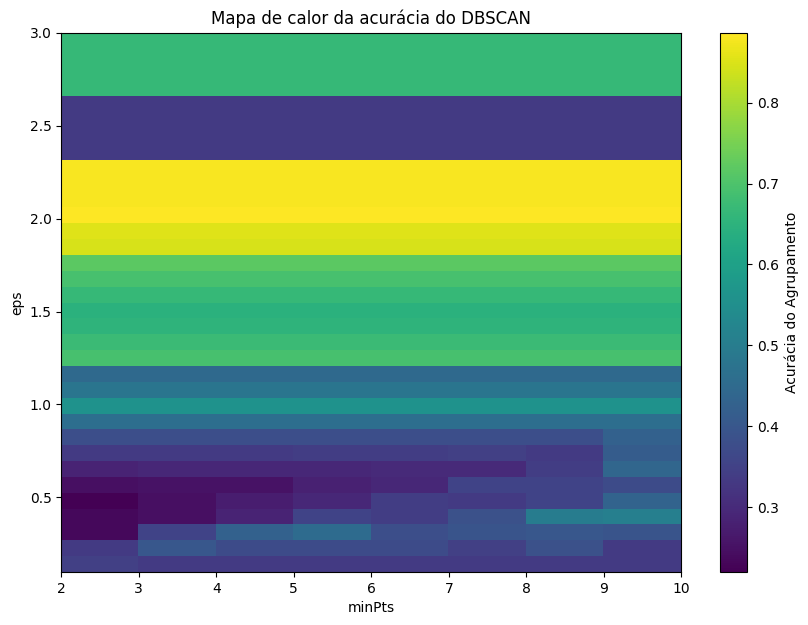

In [40]:
plt.figure(figsize=(10, 7))
heatmap_data = [[elem[0] for elem in row] for row in results]
im = plt.imshow(heatmap_data, aspect='auto', origin='lower', 
                extent=[2, 10, 0.1, 3], cmap='viridis')
plt.colorbar(im, label='Acurácia do Agrupamento')
plt.xlabel('minPts')
plt.ylabel('eps')
plt.title('Mapa de calor da acurácia do DBSCAN')
plt.show()
